In [1]:
import os 
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt

In [2]:
class BSDS500Dataset(Dataset):
    def __init__(self, root_dir, split='train', transforms=None):
        self.root_dir = root_dir
        self.split = split
        self.transforms = transforms  # Fixed typo: added transforms initialization
        self.image_files = [os.path.join(root_dir, 'images', split, f) for f in os.listdir(os.path.join(root_dir, 'images', split))]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        image = Image.open(img_name).convert('RGB')

        if self.transforms:
            image = self.transforms(image)

        return image

In [3]:
# Define data augmentation for training set
data_augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop((128, 128), scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])

# Define standard transforms for validation and test sets (no augmentation)
standard_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

root_dir = "data"
train_dataset = BSDS500Dataset(root_dir, split='train', transforms=data_augmentation_transforms)
val_dataset = BSDS500Dataset(root_dir, split='val', transforms=standard_transforms)
test_dataset = BSDS500Dataset(root_dir, split='test', transforms=standard_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

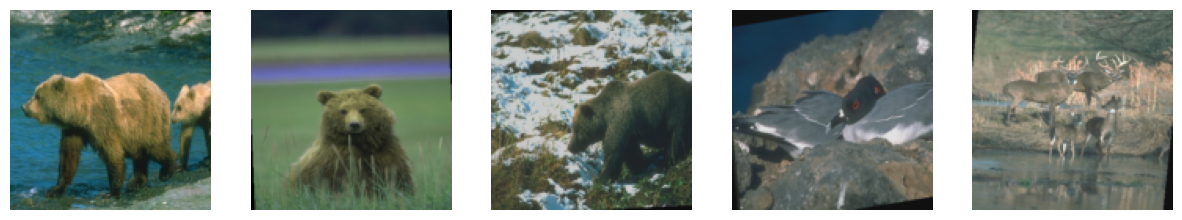

In [4]:
def visualize_augmentations(dataset, num_images=5):
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img = dataset[i]
        img = img.permute(1, 2, 0).numpy()  # Change dimension order for plotting
        axs[i].imshow(img)
        axs[i].axis('off')
    plt.show()

visualize_augmentations(train_dataset)

In [5]:
len(train_loader)

13

In [6]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, stride=1, padding=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SRCNN().to(device)

In [7]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
def calculate_metrics(output, target):
    output_np = output.permute(0, 2, 3, 1).cpu().numpy() # Changes the order of dimensions of the tensor to (batch_size, height, width, channels)
    target_np = target.permute(0, 2, 3, 1).cpu().numpy()
    ssim_val = np.mean([ssim(o, t, data_range=t.max() - t.min(), channel_axis=-1, win_size=5) for o, t in zip(output_np, target_np)]) #  channel_axis --> Specifies that the color channels are in the last dimension.
    psnr_val = np.mean([psnr(o, t, data_range=t.max() - t.min()) for o, t in zip(output_np, target_np)])
    mse_val = np.mean((output_np - target_np) ** 2)
    return ssim_val, psnr_val, mse_val

In [9]:
def visualize_progress(model, dataloader):
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs = data.to(device)
            inputs_low_resolution = F.interpolate(inputs, scale_factor=0.5, mode='bicubic', align_corners=False)
            outputs = model(inputs_low_resolution)
            outputs_upsampled = F.interpolate(outputs, size=inputs.shape[2:], mode='bicubic', align_corners=False)

            # Display the inputs, low-resolution, and output images
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            axs[0].imshow(inputs[0].cpu().permute(1, 2, 0))
            axs[0].set_title("Original Image")
            axs[1].imshow(inputs_low_resolution[0].cpu().permute(1, 2, 0))
            axs[1].set_title("Low-Resolution Image")
            axs[2].imshow(outputs_upsampled[0].cpu().permute(1, 2, 0))
            axs[2].set_title("SRCNN Image")
            plt.show()

            # only visualize one batch for simplicity
            break

### Training 

Epoch [1/100], Step [10/13], Loss: 0.0300
Validation - Epoch [1/100], SSIM: 0.3640, PSNR: 15.8767, MSE: 0.0230
Epoch [2/100], Step [10/13], Loss: 0.0187
Validation - Epoch [2/100], SSIM: 0.4420, PSNR: 17.5850, MSE: 0.0154
Epoch [3/100], Step [10/13], Loss: 0.0104
Validation - Epoch [3/100], SSIM: 0.4975, PSNR: 19.6596, MSE: 0.0096
Epoch [4/100], Step [10/13], Loss: 0.0094
Validation - Epoch [4/100], SSIM: 0.5450, PSNR: 20.9002, MSE: 0.0073
Epoch [5/100], Step [10/13], Loss: 0.0042
Validation - Epoch [5/100], SSIM: 0.5860, PSNR: 21.9816, MSE: 0.0058
Epoch [6/100], Step [10/13], Loss: 0.0054
Validation - Epoch [6/100], SSIM: 0.6097, PSNR: 22.6760, MSE: 0.0050
Epoch [7/100], Step [10/13], Loss: 0.0046
Validation - Epoch [7/100], SSIM: 0.6310, PSNR: 23.1251, MSE: 0.0045
Epoch [8/100], Step [10/13], Loss: 0.0051
Validation - Epoch [8/100], SSIM: 0.6524, PSNR: 23.5615, MSE: 0.0041
Epoch [9/100], Step [10/13], Loss: 0.0036
Validation - Epoch [9/100], SSIM: 0.6711, PSNR: 23.7463, MSE: 0.0039
E

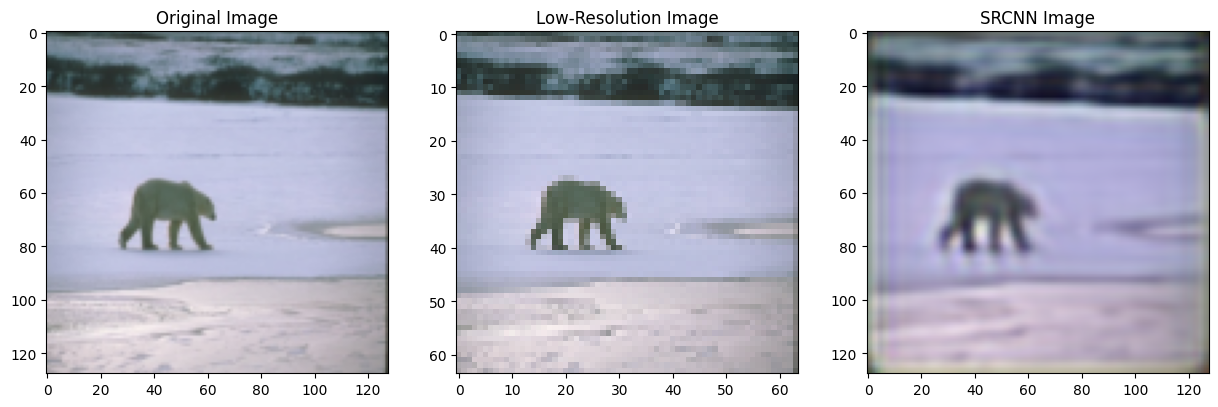

Epoch [11/100], Step [10/13], Loss: 0.0034
Validation - Epoch [11/100], SSIM: 0.7048, PSNR: 23.8271, MSE: 0.0038
Epoch [12/100], Step [10/13], Loss: 0.0034
Validation - Epoch [12/100], SSIM: 0.7189, PSNR: 24.4872, MSE: 0.0033
Epoch [13/100], Step [10/13], Loss: 0.0033
Validation - Epoch [13/100], SSIM: 0.7294, PSNR: 24.6517, MSE: 0.0032
Epoch [14/100], Step [10/13], Loss: 0.0033
Validation - Epoch [14/100], SSIM: 0.7386, PSNR: 24.9820, MSE: 0.0030
Epoch [15/100], Step [10/13], Loss: 0.0029
Validation - Epoch [15/100], SSIM: 0.7452, PSNR: 24.7164, MSE: 0.0031
Epoch [16/100], Step [10/13], Loss: 0.0045
Validation - Epoch [16/100], SSIM: 0.7477, PSNR: 22.9578, MSE: 0.0045
Epoch [17/100], Step [10/13], Loss: 0.0039
Validation - Epoch [17/100], SSIM: 0.7519, PSNR: 24.0076, MSE: 0.0036
Epoch [18/100], Step [10/13], Loss: 0.0027
Validation - Epoch [18/100], SSIM: 0.7580, PSNR: 24.4446, MSE: 0.0032
Epoch [19/100], Step [10/13], Loss: 0.0036
Validation - Epoch [19/100], SSIM: 0.7633, PSNR: 24.9

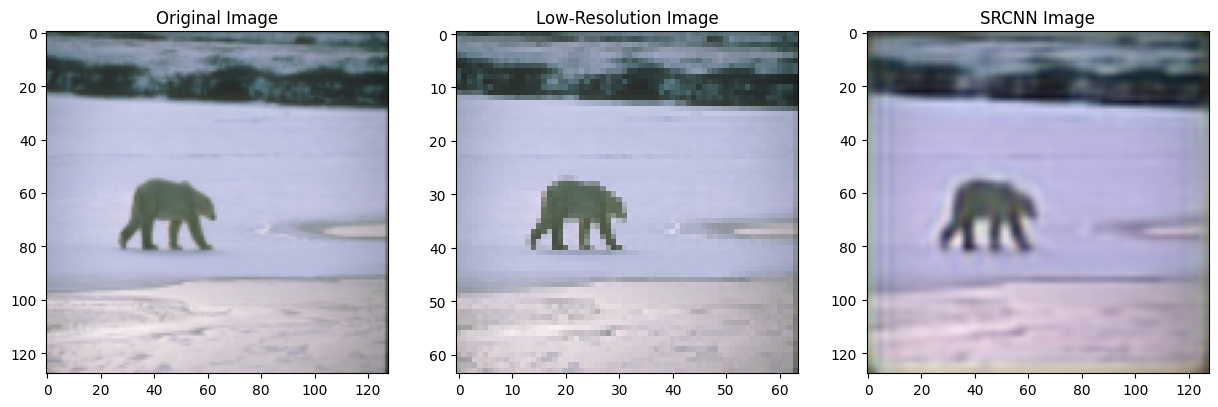

Epoch [21/100], Step [10/13], Loss: 0.0031
Validation - Epoch [21/100], SSIM: 0.7737, PSNR: 25.7583, MSE: 0.0025
Epoch [22/100], Step [10/13], Loss: 0.0029
Validation - Epoch [22/100], SSIM: 0.7777, PSNR: 25.7315, MSE: 0.0025
Epoch [23/100], Step [10/13], Loss: 0.0026
Validation - Epoch [23/100], SSIM: 0.7810, PSNR: 25.8019, MSE: 0.0025
Epoch [24/100], Step [10/13], Loss: 0.0022
Validation - Epoch [24/100], SSIM: 0.7843, PSNR: 26.2830, MSE: 0.0023
Epoch [25/100], Step [10/13], Loss: 0.0026
Validation - Epoch [25/100], SSIM: 0.7872, PSNR: 26.3419, MSE: 0.0022
Epoch [26/100], Step [10/13], Loss: 0.0026
Validation - Epoch [26/100], SSIM: 0.7667, PSNR: 21.2007, MSE: 0.0067
Epoch [27/100], Step [10/13], Loss: 0.0056
Validation - Epoch [27/100], SSIM: 0.7715, PSNR: 23.9183, MSE: 0.0036
Epoch [28/100], Step [10/13], Loss: 0.0034
Validation - Epoch [28/100], SSIM: 0.7847, PSNR: 25.9030, MSE: 0.0024
Epoch [29/100], Step [10/13], Loss: 0.0026
Validation - Epoch [29/100], SSIM: 0.7889, PSNR: 26.0

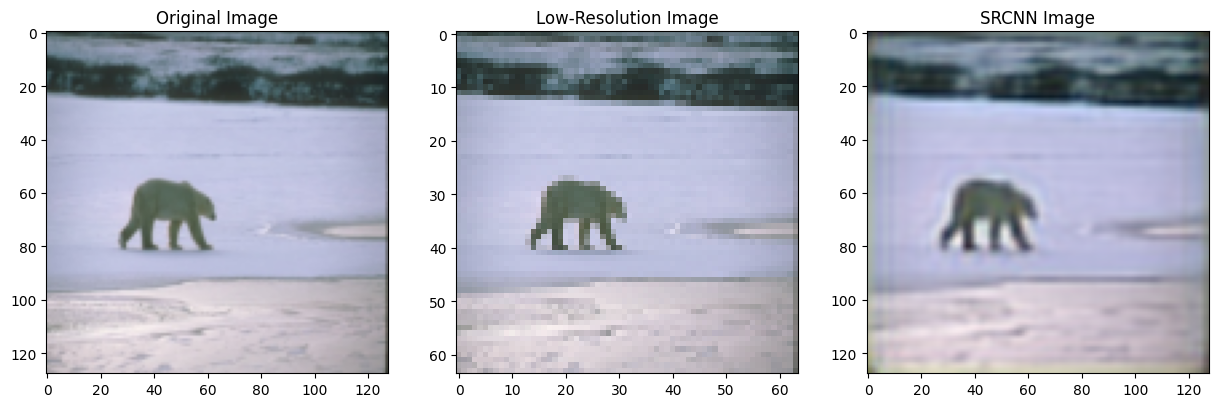

Epoch [31/100], Step [10/13], Loss: 0.0022
Validation - Epoch [31/100], SSIM: 0.7979, PSNR: 26.5063, MSE: 0.0021
Epoch [32/100], Step [10/13], Loss: 0.0026
Validation - Epoch [32/100], SSIM: 0.7987, PSNR: 25.9628, MSE: 0.0023
Epoch [33/100], Step [10/13], Loss: 0.0031
Validation - Epoch [33/100], SSIM: 0.8028, PSNR: 26.6328, MSE: 0.0021
Epoch [34/100], Step [10/13], Loss: 0.0020
Validation - Epoch [34/100], SSIM: 0.8048, PSNR: 26.8026, MSE: 0.0020
Epoch [35/100], Step [10/13], Loss: 0.0021
Validation - Epoch [35/100], SSIM: 0.8072, PSNR: 26.8794, MSE: 0.0020
Epoch [36/100], Step [10/13], Loss: 0.0022
Validation - Epoch [36/100], SSIM: 0.8097, PSNR: 26.8942, MSE: 0.0020
Epoch [37/100], Step [10/13], Loss: 0.0023
Validation - Epoch [37/100], SSIM: 0.8117, PSNR: 27.0034, MSE: 0.0019
Epoch [38/100], Step [10/13], Loss: 0.0027
Validation - Epoch [38/100], SSIM: 0.8131, PSNR: 26.7896, MSE: 0.0020
Epoch [39/100], Step [10/13], Loss: 0.0022
Validation - Epoch [39/100], SSIM: 0.8159, PSNR: 27.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Validation - Epoch [40/100], SSIM: 0.8193, PSNR: 26.8893, MSE: 0.0019


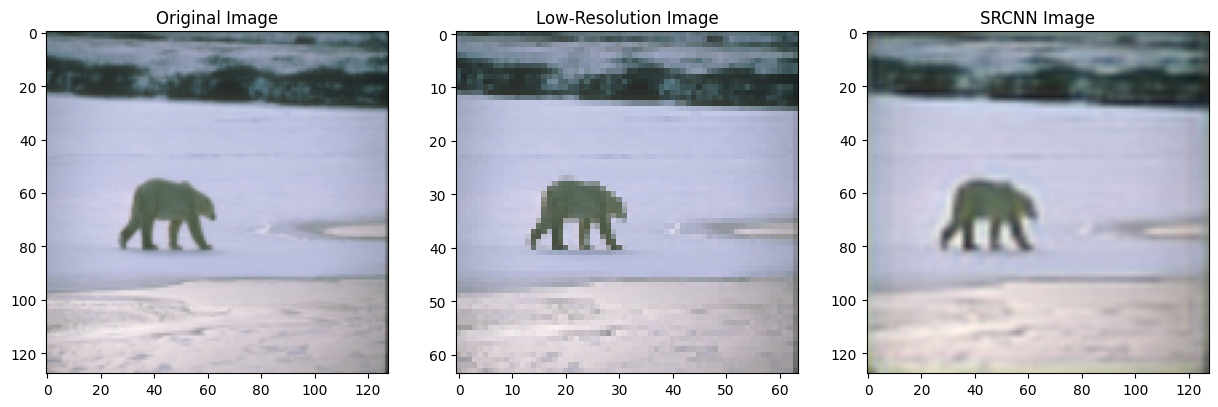

Epoch [41/100], Step [10/13], Loss: 0.0020
Validation - Epoch [41/100], SSIM: 0.8222, PSNR: 27.1154, MSE: 0.0019
Epoch [42/100], Step [10/13], Loss: 0.0027
Validation - Epoch [42/100], SSIM: 0.8240, PSNR: 27.1617, MSE: 0.0018
Epoch [43/100], Step [10/13], Loss: 0.0021
Validation - Epoch [43/100], SSIM: 0.8213, PSNR: 25.8631, MSE: 0.0023
Epoch [44/100], Step [10/13], Loss: 0.0025
Validation - Epoch [44/100], SSIM: 0.8280, PSNR: 27.0477, MSE: 0.0019
Epoch [45/100], Step [10/13], Loss: 0.0018
Validation - Epoch [45/100], SSIM: 0.8297, PSNR: 27.2239, MSE: 0.0018
Epoch [46/100], Step [10/13], Loss: 0.0025
Validation - Epoch [46/100], SSIM: 0.8292, PSNR: 26.3964, MSE: 0.0021
Epoch [47/100], Step [10/13], Loss: 0.0016
Validation - Epoch [47/100], SSIM: 0.8323, PSNR: 27.2084, MSE: 0.0018
Epoch [48/100], Step [10/13], Loss: 0.0020
Validation - Epoch [48/100], SSIM: 0.8342, PSNR: 27.5358, MSE: 0.0017
Epoch [49/100], Step [10/13], Loss: 0.0020
Validation - Epoch [49/100], SSIM: 0.8358, PSNR: 27.6

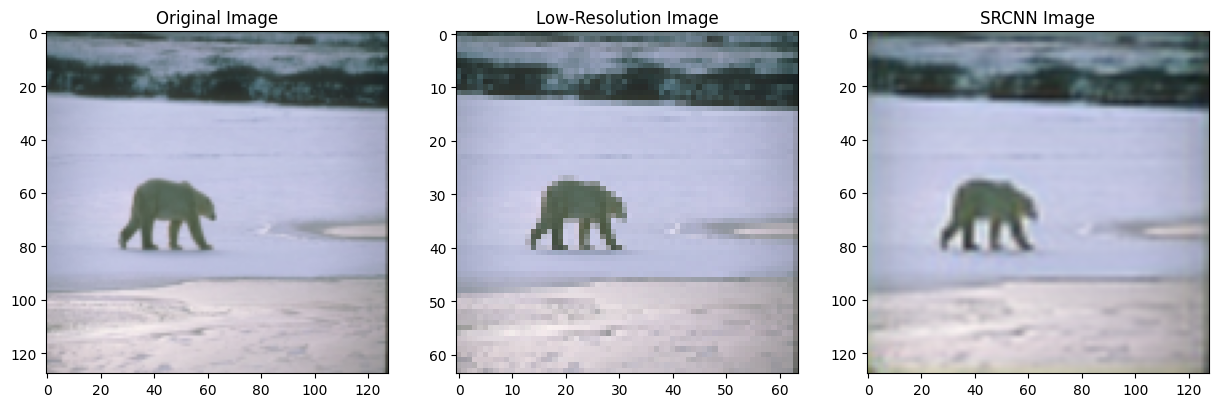

Epoch [51/100], Step [10/13], Loss: 0.0021
Validation - Epoch [51/100], SSIM: 0.8376, PSNR: 27.4102, MSE: 0.0017
Epoch [52/100], Step [10/13], Loss: 0.0019
Validation - Epoch [52/100], SSIM: 0.8390, PSNR: 27.7772, MSE: 0.0016
Epoch [53/100], Step [10/13], Loss: 0.0025
Validation - Epoch [53/100], SSIM: 0.8358, PSNR: 25.6842, MSE: 0.0024
Epoch [54/100], Step [10/13], Loss: 0.0016
Validation - Epoch [54/100], SSIM: 0.8383, PSNR: 27.2749, MSE: 0.0018
Epoch [55/100], Step [10/13], Loss: 0.0016
Validation - Epoch [55/100], SSIM: 0.8401, PSNR: 27.6721, MSE: 0.0017
Epoch [56/100], Step [10/13], Loss: 0.0019
Validation - Epoch [56/100], SSIM: 0.8415, PSNR: 27.8497, MSE: 0.0016
Epoch [57/100], Step [10/13], Loss: 0.0015
Validation - Epoch [57/100], SSIM: 0.8421, PSNR: 27.7910, MSE: 0.0016
Epoch [58/100], Step [10/13], Loss: 0.0015
Validation - Epoch [58/100], SSIM: 0.8429, PSNR: 27.7949, MSE: 0.0016
Epoch [59/100], Step [10/13], Loss: 0.0021
Validation - Epoch [59/100], SSIM: 0.8442, PSNR: 27.8

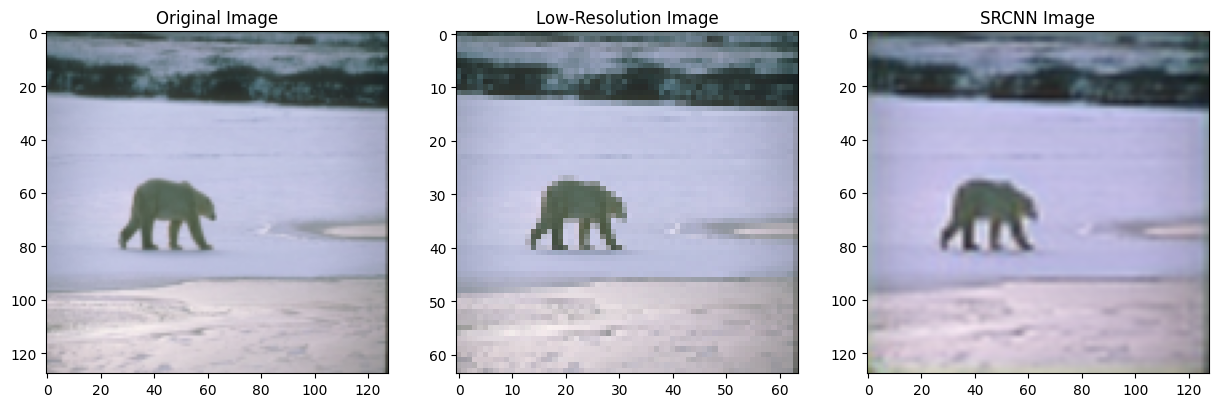

Epoch [61/100], Step [10/13], Loss: 0.0021
Validation - Epoch [61/100], SSIM: 0.8441, PSNR: 27.6699, MSE: 0.0016
Epoch [62/100], Step [10/13], Loss: 0.0020
Validation - Epoch [62/100], SSIM: 0.8446, PSNR: 27.5207, MSE: 0.0017
Epoch [63/100], Step [10/13], Loss: 0.0019
Validation - Epoch [63/100], SSIM: 0.8451, PSNR: 27.5703, MSE: 0.0017
Epoch [64/100], Step [10/13], Loss: 0.0020
Validation - Epoch [64/100], SSIM: 0.8445, PSNR: 26.4289, MSE: 0.0021
Epoch [65/100], Step [10/13], Loss: 0.0016
Validation - Epoch [65/100], SSIM: 0.8447, PSNR: 27.3340, MSE: 0.0017
Epoch [66/100], Step [10/13], Loss: 0.0017
Validation - Epoch [66/100], SSIM: 0.8453, PSNR: 27.7493, MSE: 0.0016
Epoch [67/100], Step [10/13], Loss: 0.0019
Validation - Epoch [67/100], SSIM: 0.8469, PSNR: 27.9565, MSE: 0.0016
Epoch [68/100], Step [10/13], Loss: 0.0015
Validation - Epoch [68/100], SSIM: 0.8478, PSNR: 28.0890, MSE: 0.0015
Epoch [69/100], Step [10/13], Loss: 0.0018
Validation - Epoch [69/100], SSIM: 0.8484, PSNR: 28.1

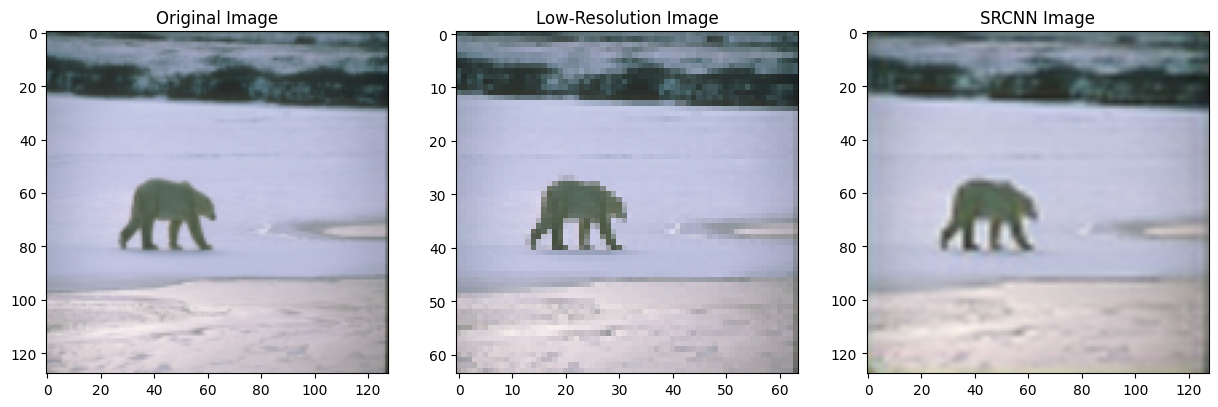

Epoch [71/100], Step [10/13], Loss: 0.0018
Validation - Epoch [71/100], SSIM: 0.8490, PSNR: 27.7392, MSE: 0.0016
Epoch [72/100], Step [10/13], Loss: 0.0018
Validation - Epoch [72/100], SSIM: 0.8498, PSNR: 28.0227, MSE: 0.0015
Epoch [73/100], Step [10/13], Loss: 0.0021
Validation - Epoch [73/100], SSIM: 0.8499, PSNR: 27.8908, MSE: 0.0016
Epoch [74/100], Step [10/13], Loss: 0.0013
Validation - Epoch [74/100], SSIM: 0.8504, PSNR: 27.9991, MSE: 0.0015
Epoch [75/100], Step [10/13], Loss: 0.0020
Validation - Epoch [75/100], SSIM: 0.8509, PSNR: 28.0333, MSE: 0.0015
Epoch [76/100], Step [10/13], Loss: 0.0019
Validation - Epoch [76/100], SSIM: 0.8515, PSNR: 28.0062, MSE: 0.0015
Epoch [77/100], Step [10/13], Loss: 0.0015
Validation - Epoch [77/100], SSIM: 0.8510, PSNR: 27.5227, MSE: 0.0017
Epoch [78/100], Step [10/13], Loss: 0.0021
Validation - Epoch [78/100], SSIM: 0.8508, PSNR: 26.4780, MSE: 0.0020
Epoch [79/100], Step [10/13], Loss: 0.0023
Validation - Epoch [79/100], SSIM: 0.8454, PSNR: 23.8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Validation - Epoch [80/100], SSIM: 0.8483, PSNR: 26.6576, MSE: 0.0020


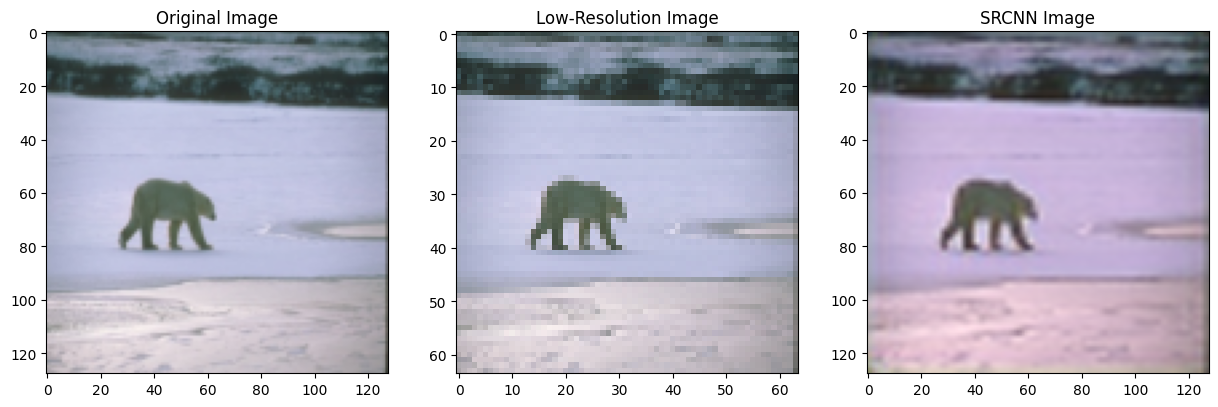

Epoch [81/100], Step [10/13], Loss: 0.0014
Validation - Epoch [81/100], SSIM: 0.8483, PSNR: 26.0984, MSE: 0.0022
Epoch [82/100], Step [10/13], Loss: 0.0019
Validation - Epoch [82/100], SSIM: 0.8498, PSNR: 27.2359, MSE: 0.0018
Epoch [83/100], Step [10/13], Loss: 0.0014
Validation - Epoch [83/100], SSIM: 0.8514, PSNR: 27.9737, MSE: 0.0015
Epoch [84/100], Step [10/13], Loss: 0.0017
Validation - Epoch [84/100], SSIM: 0.8528, PSNR: 28.2431, MSE: 0.0015
Epoch [85/100], Step [10/13], Loss: 0.0016
Validation - Epoch [85/100], SSIM: 0.8533, PSNR: 28.2573, MSE: 0.0015
Epoch [86/100], Step [10/13], Loss: 0.0014
Validation - Epoch [86/100], SSIM: 0.8533, PSNR: 28.0096, MSE: 0.0015
Epoch [87/100], Step [10/13], Loss: 0.0021
Validation - Epoch [87/100], SSIM: 0.8542, PSNR: 28.2253, MSE: 0.0015
Epoch [88/100], Step [10/13], Loss: 0.0016
Validation - Epoch [88/100], SSIM: 0.8534, PSNR: 27.6724, MSE: 0.0016
Epoch [89/100], Step [10/13], Loss: 0.0018
Validation - Epoch [89/100], SSIM: 0.8513, PSNR: 27.4

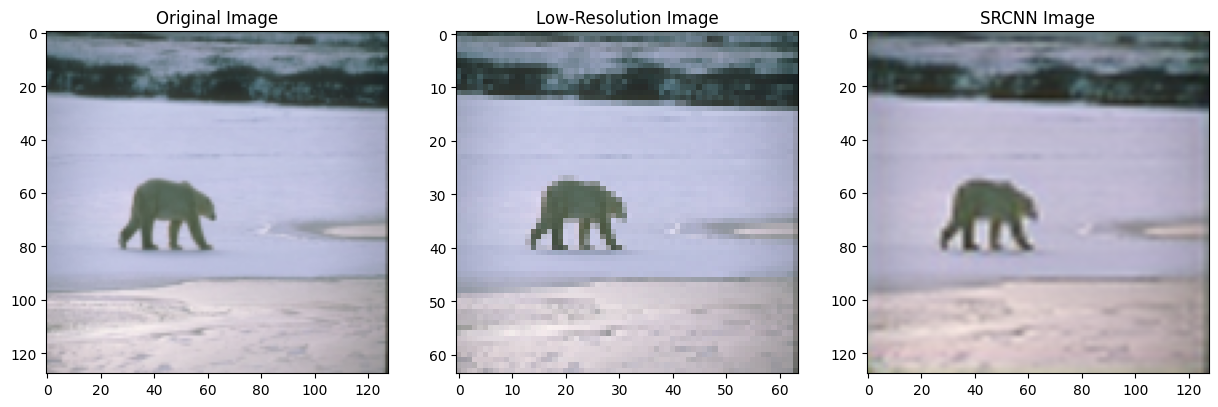

Epoch [91/100], Step [10/13], Loss: 0.0021
Validation - Epoch [91/100], SSIM: 0.8504, PSNR: 26.7103, MSE: 0.0019
Epoch [92/100], Step [10/13], Loss: 0.0018
Validation - Epoch [92/100], SSIM: 0.8543, PSNR: 27.8299, MSE: 0.0016
Epoch [93/100], Step [10/13], Loss: 0.0021
Validation - Epoch [93/100], SSIM: 0.8526, PSNR: 25.6805, MSE: 0.0024
Epoch [94/100], Step [10/13], Loss: 0.0021
Validation - Epoch [94/100], SSIM: 0.8484, PSNR: 25.3920, MSE: 0.0026
Epoch [95/100], Step [10/13], Loss: 0.0020
Validation - Epoch [95/100], SSIM: 0.8539, PSNR: 28.1493, MSE: 0.0015
Epoch [96/100], Step [10/13], Loss: 0.0015
Validation - Epoch [96/100], SSIM: 0.8500, PSNR: 24.4340, MSE: 0.0032
Epoch [97/100], Step [10/13], Loss: 0.0023
Validation - Epoch [97/100], SSIM: 0.8530, PSNR: 27.7960, MSE: 0.0016
Epoch [98/100], Step [10/13], Loss: 0.0025
Validation - Epoch [98/100], SSIM: 0.8514, PSNR: 26.8536, MSE: 0.0019
Epoch [99/100], Step [10/13], Loss: 0.0015
Validation - Epoch [99/100], SSIM: 0.8533, PSNR: 27.9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


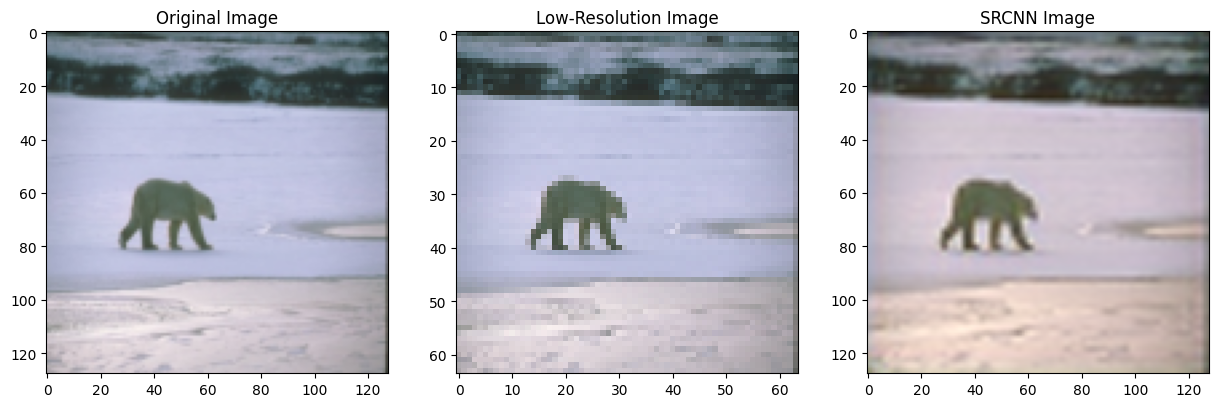

In [10]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for i, data in enumerate(train_loader):
        inputs = data.to(device)
        inputs_low_res = F.interpolate(inputs, scale_factor=0.5, mode='bicubic', align_corners=False)
        outputs = model(inputs_low_res)
        outputs_upsampled = F.interpolate(outputs, size=inputs.shape[2:], mode='bicubic', align_corners=False)
        loss = criterion(outputs_upsampled, inputs)

        optimizer.zero_grad() # Reset gradients to zero to avoid accumulation from previous batches.
        loss.backward() # Compute the gradient of the loss with respect to the model parameters.
        optimizer.step() # Update the model parameters using the computed gradients.
        if (i+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}') # 13 batches of data.
    
    # Validation
    model.eval()
    ssim_total, psnr_total, mse_total = 0, 0, 0
    with torch.no_grad():
        for data in val_loader:
            inputs = data.to(device)
            inputs_low_res = F.interpolate(inputs, scale_factor=0.5, mode='bicubic', align_corners=False)
            outputs = model(inputs_low_res)
            outputs_upsampled = F.interpolate(outputs, size=inputs.shape[2:], mode='bicubic', align_corners=False)
            ssim_val, psnr_val, mse_val = calculate_metrics(outputs_upsampled, inputs)
            ssim_total += ssim_val
            psnr_total += psnr_val
            mse_total += mse_val

    print(f'Validation - Epoch [{epoch+1}/{num_epochs}], SSIM: {ssim_total/len(val_loader):.4f}, PSNR: {psnr_total/len(val_loader):.4f}, MSE: {mse_total/len(val_loader):.4f}')
    
    # Visualize progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        visualize_progress(model, test_loader)

In [11]:
def visualize_progress(model, dataloader):
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs = data.to(device)
            inputs_low_resolution = F.interpolate(inputs, scale_factor=0.5, mode='bicubic', align_corners=False)
            outputs = model(inputs_low_resolution)
            outputs_upsampled = F.interpolate(outputs, size=inputs.shape[2:], mode='bicubic', align_corners=False)

            # Display the inputs, low-resolution, and output images
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            axs[0].imshow(inputs[0].cpu().permute(1, 2, 0))
            axs[0].set_title("Original Image")
            axs[1].imshow(inputs_low_resolution[0].cpu().permute(1, 2, 0))
            axs[1].set_title("Low-Resolution Image")
            axs[2].imshow(outputs_upsampled[0].cpu().permute(1, 2, 0))
            axs[2].set_title("SRCNN Image")
            plt.show()

            # only visualize one batch for simplicity
            break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


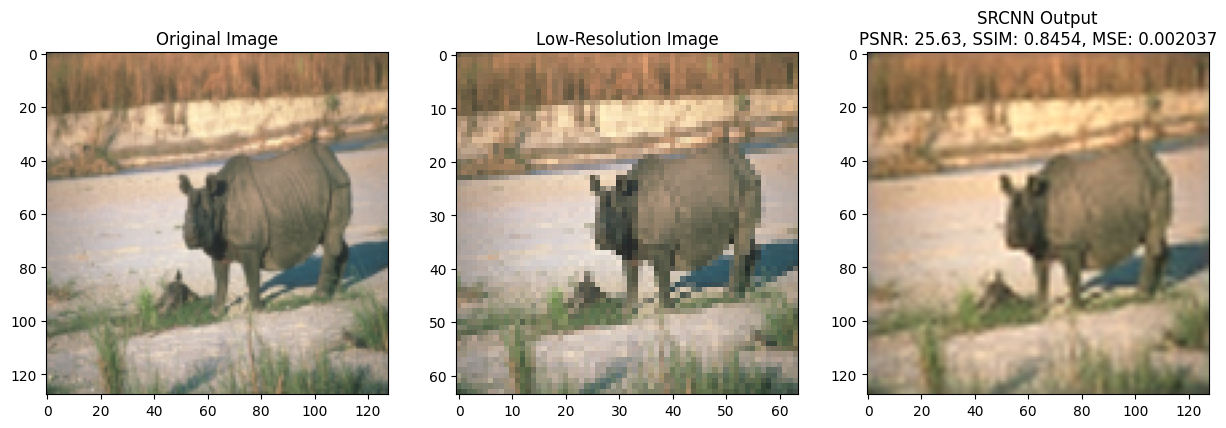

In [17]:
def visualize_one_random_image(model, dataloader):
    model.eval()
    with torch.no_grad():
        data_iter = iter(dataloader)
        data = next(data_iter)
        inputs = data.to(device)
        inputs_low_res = F.interpolate(inputs, scale_factor=0.5, mode='bicubic', align_corners=False)
        outputs = model(inputs_low_res)
        outputs_upsampled = F.interpolate(outputs, size=inputs.shape[2:], mode='bicubic', align_corners=False)

        # Calculate metrics
        ssim_val, psnr_val, mse_val = calculate_metrics(outputs_upsampled, inputs)

        # Display the input, low-res, and output images
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(inputs[0].cpu().permute(1, 2, 0))
        axs[0].set_title('Original Image')
        axs[1].imshow(inputs_low_res[0].cpu().permute(1, 2, 0))
        axs[1].set_title('Low-Resolution Image')
        axs[2].imshow(outputs_upsampled[0].cpu().permute(1, 2, 0))
        axs[2].set_title(f'SRCNN Output\nPSNR: {psnr_val:.2f}, SSIM: {ssim_val:.4f}, MSE: {mse_val:.6f}')
        plt.show()

visualize_one_random_image(model, DataLoader(test_dataset, batch_size=1, shuffle=True))